# 1. Integración de LLMs en LangChain

**¿Qué es un modelo?**

Un modelo en LangChain es un modelo de aprendizaje automático pre-entrenado que se puede utilizar para realizar una tarea específica como generar texto, traducir idiomas o responder preguntas. Con LangChain puedes usar una variedad de modelos y utilizarlos para crear aplicaciones de IA sin tener que entrenar tus propios modelos desde cero.

**Ventajas de usar modelos de LangChain**

Hay varias ventajas de usar modelos de LangChain:

* **Consistencia:** Los modelos de LangChain proporcionan una interfaz consistente, independientemente de si está utilizando OpenAI o Hugging Face. Esto hace que sea más fácil aprender y usar los modelos de LangChain, y cambiar entre diferentes modelos si es necesario.
* **Eficiencia:** Los modelos de LangChain están pre-entrenados y alojados en la nube, lo que los hace mucho más rápidos de usar que entrenar sus propios modelos.
* **Flexibilidad:** Los modelos de LangChain se pueden utilizar para una variedad de tareas, como la comprensión del lenguaje natural, la traducción automática y el análisis de sentimientos.

**Ejemplos prácticos de uso de modelos de LangChain**

* **Generación de texto:** Utiliza un LLM para generar texto,indicando estilo, tono, publico objetivo y mas.
* **Traducción de idiomas:** Traduce un texto de un idioma a otro con modelos de lenguaje.
* **Escritura de diferentes tipos de contenido creativo:** Usa un modelo de lenguaje para escribir diferentes tipos de contenido creativo, como poemas, código, guiones, piezas musicales, correo electrónico, cartas, etc.
* **Respuesta a sus preguntas de forma informativa:** Utiliza un modelo de preguntas y respuestas para responder con información del modelo o que pueda consultar en otras fuentes, incluso si son abiertas, desafiantes o extrañas.


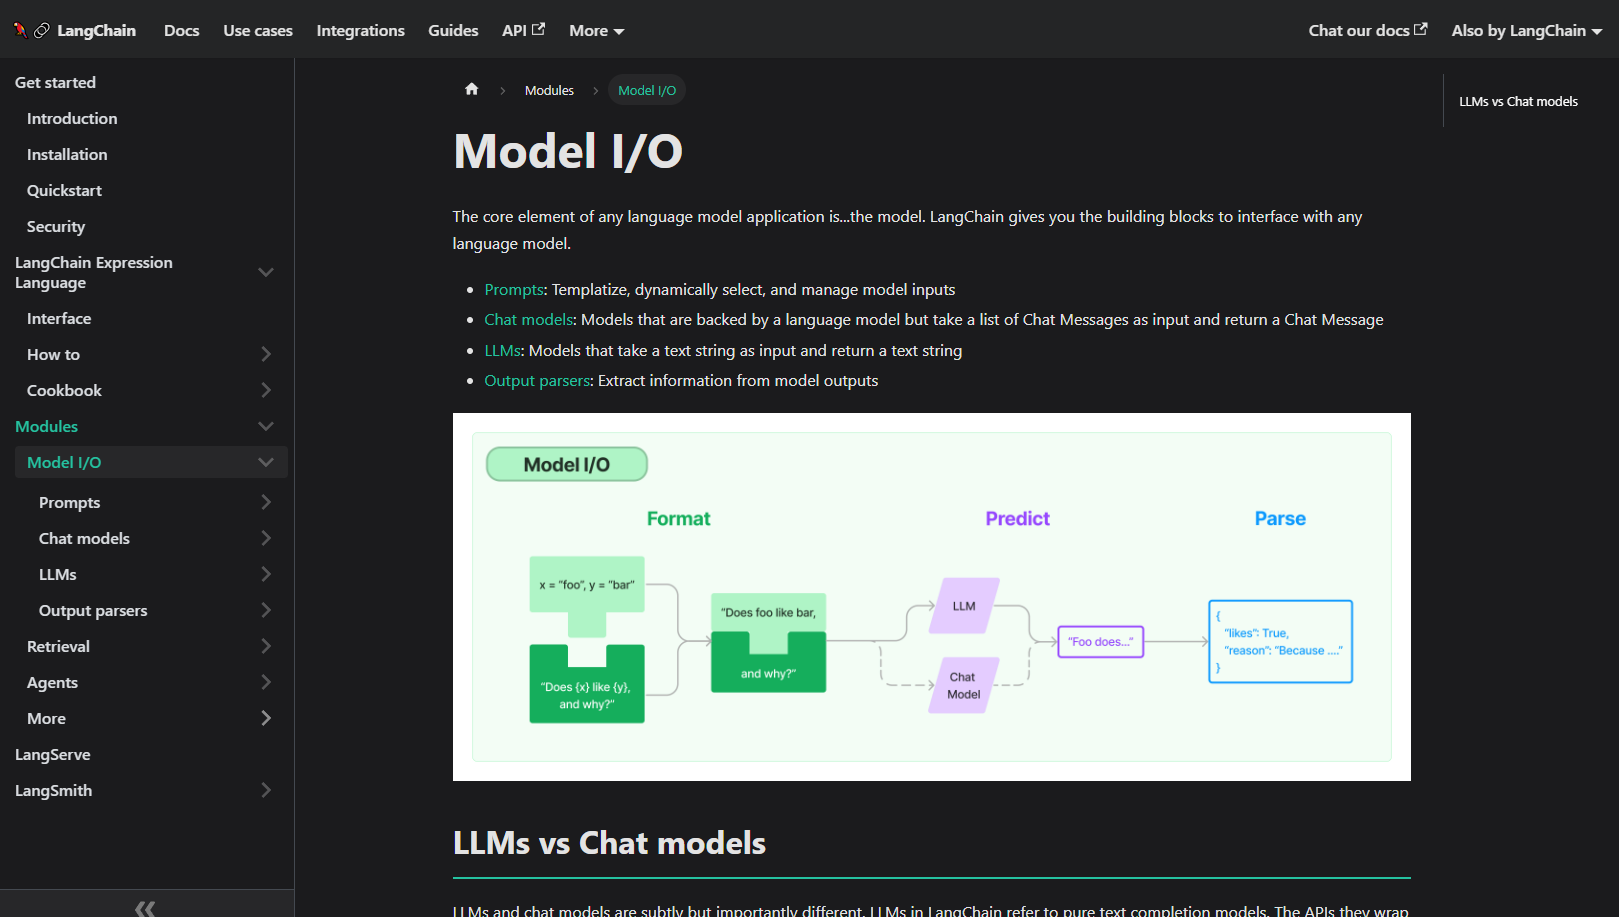

LangChain tiene integraciones con varios modelos o plataformas de modelos, como el Hugging Face Hub. Con el tiempo, habrá disponibles más integraciones y modelos.

LangChain Models Docs: https://python.langchain.com/docs/modules/model_io/

## 1.1 Uso de modelos Open Source de Hugging Face

In [ ]:
%%capture
!pip install langchain

Los modelos de Hugging Face requieren instalación de `einops`. Para utilizar `low_cpu_mem_usage=True` o `device_map` es necesario contar con `Accelerate` instalado: `pip install accelerate`.

In [ ]:
%%capture
!pip install -q transformers einops accelerate

Se debe tener en cuenta que entre más grande el `max_length`, es decir la cantidad de texto que podemos incluir en una consulta a nuestro modelo, más recursos computacionales se requieren. Vamos a usar los pipelines de Hugging Face: https://huggingface.co/docs/transformers/main/en/main_classes/pipelines

In [ ]:
from transformers import AutoTokenizer, pipeline
import torch

# model = "tiiuae/falcon-40b-instruct"
# model = "stabilityai/stablelm-tuned-alpha-3b"
model = "tiiuae/falcon-7b-instruct"

tokenizer = AutoTokenizer.from_pretrained(model)

pipeline = pipeline(
    "text-generation", #tarea
    model=model, #modelo
    tokenizer=tokenizer, # tokenizador para convertir en token las frases
    torch_dtype=torch.bfloat16, # con que tipo de datos va a trabajar el modelo
    trust_remote_code=True, # Este es un modelo externo que no pertenece nativamente transformers
    device_map="auto" # Para cargar el modelo en GPU, CPU o Ambos
)

Podemos enviar preguntas directamente al pipeline de Hugging Face para generar texto con nuestro modelo. Sin embargo, LangChain nos facilita la vida.

In [ ]:
type(pipeline)

In [ ]:
from langchain import HuggingFacePipeline # para integrar a langchain

llm_falcon = HuggingFacePipeline(
    pipeline = pipeline,
    model_kwargs = { # esto lo podimos hacer el cargar el modelo, pero deberiamos
                     # volver a descargar todo ante cada cambio
        'temperature': 0,       # nivel creatividad o alucinacion
        'max_length': 150,      # maximo de largo de respuesta
        'do_sample': True,      # sampleo aleatorio entre respuesta
        'top_k': 10,            # cantidad de respuestas aleatorias
        'num_return_sequences':1, # cantidad de respuestas
        'eos_token_id': tokenizer.eos_token_id #cual es el eos token
    }
)



In [ ]:
llm_falcon

In [ ]:
llm_falcon("What is AI?")

Los modelos de código abierto de Hugging Face son increíblemente poderosos. Sin embargo, al utilizarlos de esta manera, los descargamos y ejecutamos en nuestra propia máquina. Ahí es donde existen algunas complicaciones, ya que esto puede ser lento a menos que se cuente con el hardware adecuado.

Ahora piensa en modelos que provienen de API y servicios de OpenAI, Cohere y otros proveedores de modelos remotos (que normalmente no son de código abierto). La magia de estos modelos es que funcionan en sus servidores, no en nuestra máquina.

Es como si estuvieras invitado a una fiesta. Podrías hacer la fiesta en tu casa (como usar los modelos de Hugging Face en tu máquina), pero tendrías que hacer la limpieza antes y después, y preocuparte por la música, la comida, etc. En cambio, si la fiesta se celebra en un restaurante o salón dedicado a fiestas (como usar modelos de OpenAI o Cohere en sus servidores), solo tienes que llegar y disfrutar.

Por esto, vamos a seguir utilizando los modelos de la [API de OpenAI](https://platzi.com/cursos/openai). Todo lo que vamos a hacer a partir de ahora también se puede aplicar a los modelos descargados de Hugging Face.

## 1.2 Uso de modelos de OpenAI API

La clase `langchain.llms.OpenAI` nos permite inicializar un modelo de proveedor OpenAI.

In [ ]:
%%capture
!pip install openai langchain

Es necesario configurar la API Key de tu cuenta de OpenAI.

In [ ]:
!openai --version

In [ ]:
from getpass import getpass
import os

OPENAI_API_KEY = getpass('Enter the secret value: ')
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

Para usar al máximo los LLM con LangChain, tenemos que ajustar unas cuantas configuraciones básicas:

1. `model_name` - ¿Qué modelo vamos a usar?
    Por ejemplo, "text-davinci-003" (que es el valor por defecto) o "text-ada-001". Estos nombres cambian según quién haya creado el modelo, así que necesitas revisar la documentación de la API del proveedor que estás utilizando para encontrar el nombre específico de tu modelo.

2. `n` - La cantidad de respuestas distintas que vamos a generar para la pregunta dada (el número estándar es 1)

3. `streaming` - ¿Queremos que los resultados se transmitan poco a poco? (por defecto es "Falso").
    Esto es como decidir si preferimos escuchar una canción entera de una vez, o escucharla nota por nota. Esto es especialmente útil cuando estás armando una experiencia de chatbot y quieres que el texto aparezca línea por línea, en lugar de un solo bloque de respuesta.

4. `temperature` - Aquí ajustamos la "temperatura de muestreo" en un rango de 0 a 1.
    Imagina que la temperatura es como ajustar el nivel de improvisación de un solo de guitarra. Si la temperatura es 0, el LLM solo es "preciso" y siempre tocará las notas más probables. Siempre va a sonar igual para la misma canción. Pero si la temperatura es 1, el solo será "creativo" y va a tocar notas diferentes cada vez que lo escuches, a veces incluso notas que te sorprenden. El valor estándar es 0.7, lo que se considera lo suficientemente creativo pero no completamente aleatorio, como un solo de guitarra que sale un poco de los rieles, pero no tanto como para descarrilar la canción.


In [ ]:
from langchain.llms import OpenAI

llm_gpt3_5 = OpenAI(
    model_name="gpt-3.5-turbo",
    n=1,
    temperature=0.3
)

OpenAI a cambiado su api recientemente con lo cual ahora LangChain esta adaptando sus modulos. Exites el modulo llm para uso de modelos del lenguaje. Pero tambien tenemos chat_models para modelos adaptados a esta tarea especifica.

In [ ]:
from langchain.chat_models import ChatOpenAI

llm_gpt3_5 = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.3
)

Una vez que el modelo LLM está configurado, podemos interactuar con él de la misma manera que lo haríamos con ChatGPT. Haciendo uso del metodo invoke o generate

In [ ]:
llm_gpt3_5.invoke("Cómo puedo lograr una clase más divertida para estudiantes por zoom?")

Además, la función `generate` nos permite pasar una lista de entradas de prompts, lo cual produce una salida más detallada que incluye información como el uso de tokens. Esta información de uso de tokens puede ser útil para realizar un seguimiento de los tokens y estimar los costos.

In [ ]:
from langchain.llms import OpenAI

llm_davinci = OpenAI(
    model_name="text-davinci-003",
    n=2,
    temperature=0.3
    )

In [ ]:
generacion = llm_davinci.generate(
    ["Dime que sabes de Argentina", "Recomiendame que ciudades de Argentina visitar"]
    )

In [ ]:
generacion.generations

In [ ]:
generacion.llm_output

Otra función útil proporcionada por la clase LLM es `get_num_tokens`, que estima el número de tokens y fragmentos de texto contenidos en una entrada. Esta información es valiosa cuando se necesita limitar el número total de tokens o cumplir con un presupuesto específico.

In [ ]:
%%capture
!pip install tiktoken

In [ ]:
llm_gpt3_5.get_num_tokens("mi tarjeta de credito va a explotar, me preocupa gastar mucho en openai")